## Import packages necessary for modeling

In [70]:
!pip install imbalanced-learn

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from collections import Counter

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Read in crash dataset from 2019 - 2024

In [60]:
df = pd.read_csv('/content/drive/MyDrive/model_df.csv')
del df['YEAR']

## Dataset Summary



*   199,731 rows
*   9 features
*   9 categorical variables


In [61]:
df.head(5)

,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ROADWAY_SURFACE_COND,zip,POSTED_SPEED_LIMIT,severe
0,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,STATIONARY/FIXED,DIVIDED ROAD,DRY,60608,(26-35) MODERATE,0
1,TRAFFIC SIGNAL,FUNCTIONING IMPROPERLY,CLEAR,DAYLIGHT,INTERSECTION,INTERSECTION,DRY,60621,(26-35) MODERATE,0
2,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR IMPACT,UNDIVIDED ROAD,DRY,60625,(26-35) MODERATE,0
3,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,INTERSECTION,INTERSECTION,DRY,60614,(26-35) MODERATE,0
4,NO CONTROLS,NOT FUNCTIONING,CLEAR,DAYLIGHT,STATIONARY/FIXED,UNDIVIDED ROAD,DRY,60639,(16-25) LOW,0


In [62]:
df.shape

(199731, 10)

In [63]:
counts = df['severe'].value_counts()

severe = counts.get(1, 0)
non_severe = counts.get(0, 0)

print(f'Total Non-Severe Cases: {non_severe}')
print(f'Total Severe Cases: {severe}')

Total Non-Severe Cases: 194675
Total Severe Cases: 5056


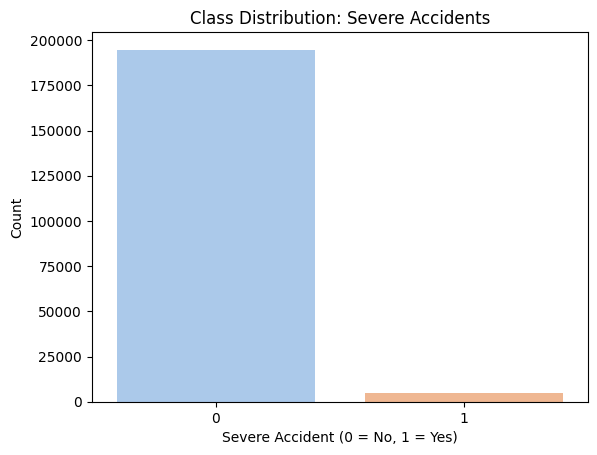

In [64]:
sns.countplot(x='severe', hue = 'severe', data=df, palette = 'pastel', legend = False)
plt.title('Class Distribution: Severe Accidents')
plt.xlabel('Severe Accident (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

In [65]:
colnames = df.columns
unique_data = {
    col: ', '.join(map(str, df[col].dropna().unique())) for col in colnames
}

unique_df = pd.DataFrame.from_dict(unique_data, orient='index', columns=['Unique Values'])
unique_df

,Unique Values
TRAFFIC_CONTROL_DEVICE,"TRAFFIC SIGNAL, STOP SIGN/FLASHER, NO CONTROLS..."
DEVICE_CONDITION,"FUNCTIONING PROPERLY, FUNCTIONING IMPROPERLY, ..."
WEATHER_CONDITION,"CLEAR, CLOUDY/OVERCAST, RAIN, SNOW"
LIGHTING_CONDITION,"DAYLIGHT, DARKNESS, LIGHTED ROAD, LOW LIGHT, D..."
FIRST_CRASH_TYPE,"STATIONARY/FIXED, INTERSECTION, REAR IMPACT, P..."
TRAFFICWAY_TYPE,"DIVIDED ROAD, INTERSECTION, UNDIVIDED ROAD, ST..."
ROADWAY_SURFACE_COND,"DRY, WET, SNOW OR SLUSH, ICE"
zip,"60608, 60621, 60625, 60614, 60639, 60646, 6064..."
POSTED_SPEED_LIMIT,"(26-35) MODERATE, (16-25) LOW, (36-45) HIGH, (..."
severe,"0, 1"


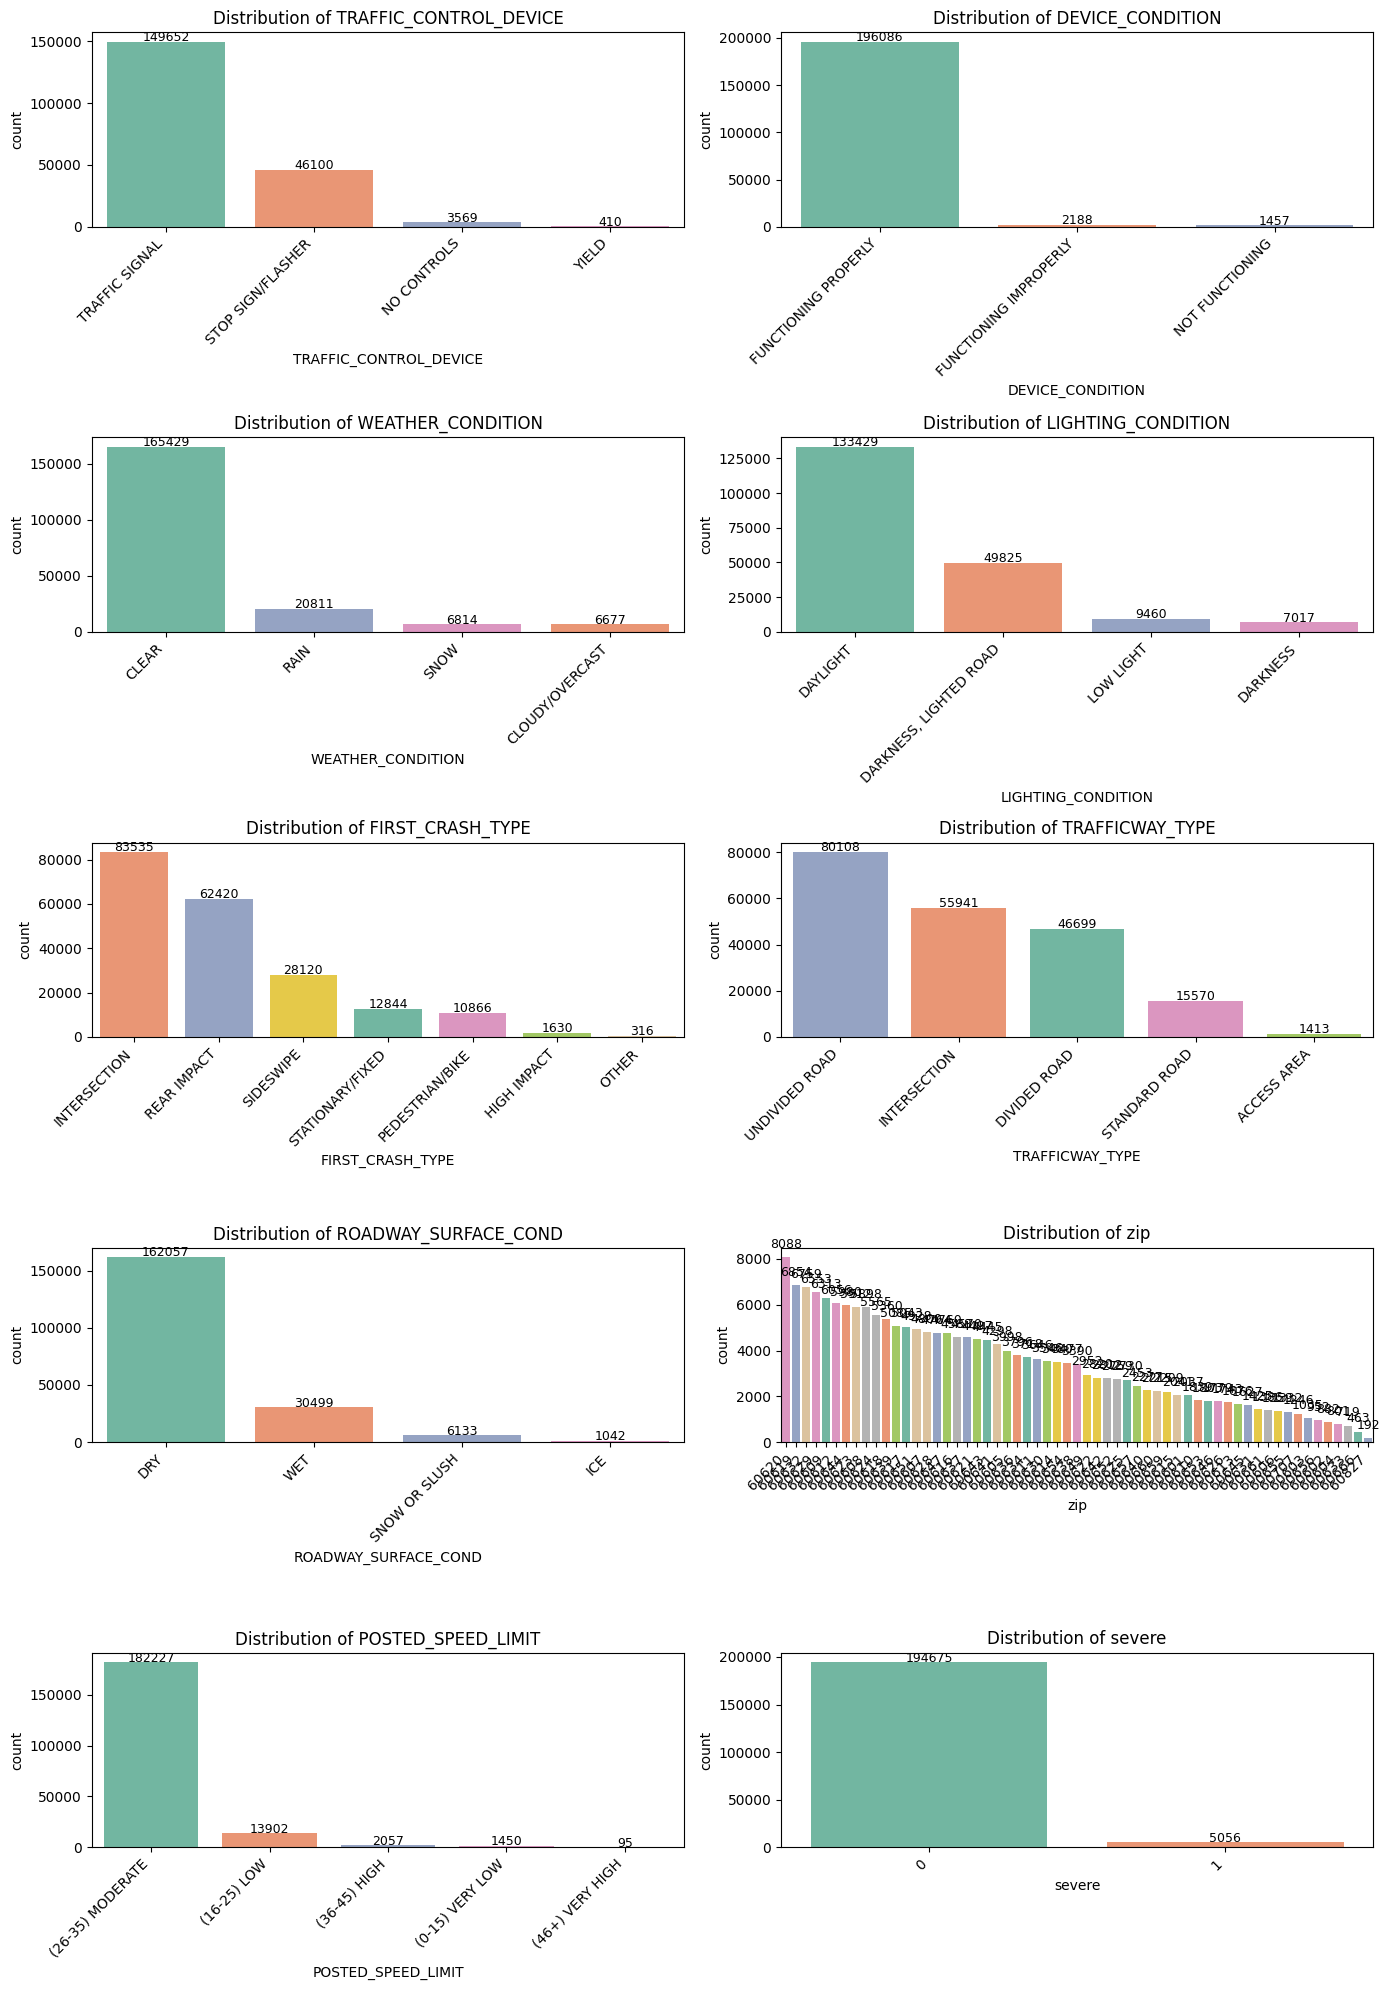

In [66]:
num_cols = len(colnames)
n_cols = 2
n_rows = (num_cols + n_cols - 1) // n_cols

plt.figure(figsize=(14, n_rows * 4))

for i, col in enumerate(colnames):
    plt.subplot(n_rows, n_cols, i + 1)

    order = df[col].value_counts().index
    palette = sns.color_palette("Set2", n_colors=len(order))

    ax = sns.countplot(data=df, x=col, hue=col, order=order, palette=palette, legend=False)

    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(p.get_x() + p.get_width() / 2., height + 400,
                    f'{int(height)}', ha="center", fontsize=9)

    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

plt.show()


## USE LABEL ENCODER TO TRANSFORM CATEGORICAL VARIABLES TO NUMERICAL FOR MACHINE LEARNING

In [67]:
from sklearn.preprocessing import LabelEncoder

encoders = {}
mappings = {}

for col in df.columns:
    if col != 'severe':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        encoders[col] = le
        mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))


In [69]:
df.head(5)

,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ROADWAY_SURFACE_COND,zip,POSTED_SPEED_LIMIT,severe
0,2,1,0,2,6,1,0,7,2,0
1,2,0,0,2,1,2,0,20,2,0
2,2,1,0,2,4,4,0,24,2,0
3,1,1,0,2,1,2,0,13,2,0
4,0,2,0,2,6,4,0,36,1,0


## APPLY SMOTE TO ADDRESS CLASS IMBALANCE

In [76]:
X = df.drop(columns=['severe'])
y = df['severe']

print('Before SMOTE:', Counter(y))

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print('After SMOTE:', Counter(y_resampled))

Before SMOTE: Counter({0: 194675, 1: 5056})
After SMOTE: Counter({0: 194675, 1: 194675})


In [77]:
df_balanced = pd.DataFrame(X_resampled, columns=X.columns)
df_balanced['severe'] = y_resampled

In [78]:
df_balanced.head(5)

,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ROADWAY_SURFACE_COND,zip,POSTED_SPEED_LIMIT,severe
0,2,1,0,2,6,1,0,7,2,0
1,2,0,0,2,1,2,0,20,2,0
2,2,1,0,2,4,4,0,24,2,0
3,1,1,0,2,1,2,0,13,2,0
4,0,2,0,2,6,4,0,36,1,0


In [79]:
df_balanced['severe'].value_counts()

,count
severe,
0,194675
1,194675


In [81]:
df_balanced.shape

(389350, 10)

## Baseline Model: Logistic Regression (No SMOTE)

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Fit logistic regression baseline model using data without SMOTE
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
lr_baseline = LogisticRegression(random_state=seed)
lr_baseline.fit(X_train, y_train)

# Generate prediction values
y_pred = lr_baseline.predict(X_test)
y_prob = lr_baseline.predict_proba(X_test)[:, 1]

# Evaluate classification model on test set and generate model metrics for baseline
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division = 0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99     38911
           1       0.00      0.00      0.00      1036

    accuracy                           0.97     39947
   macro avg       0.49      0.50      0.49     39947
weighted avg       0.95      0.97      0.96     39947

Confusion Matrix:
 [[38911     0]
 [ 1036     0]]
ROC-AUC Score: 0.6029283091232154


## Baseline Model: Logistic Regression (with SMOTE)

In [111]:
# Create random forest classifier model
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=seed)
lr_baseline = LogisticRegression(random_state=seed)
lr_baseline.fit(X_train, y_train)

# Generate prediction values
y_pred = lr_baseline.predict(X_test)
y_prob = lr_baseline.predict_proba(X_test)[:, 1]

# Evaluate classification model on test set and generate model metrics for baseline with SMOTE
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division = 0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.60      0.60     39011
           1       0.60      0.59      0.59     38859

    accuracy                           0.60     77870
   macro avg       0.60      0.60      0.60     77870
weighted avg       0.60      0.60      0.60     77870

Confusion Matrix:
 [[23474 15537]
 [15979 22880]]
ROC-AUC Score: 0.6513177766742999


## Model 1: Random Forest Classifier (with SMOTE)

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.76      0.81     39011
           1       0.79      0.88      0.83     38859

    accuracy                           0.82     77870
   macro avg       0.83      0.82      0.82     77870
weighted avg       0.83      0.82      0.82     77870

Confusion Matrix:
 [[29669  9342]
 [ 4587 34272]]
ROC-AUC Score: 0.9080525300571094


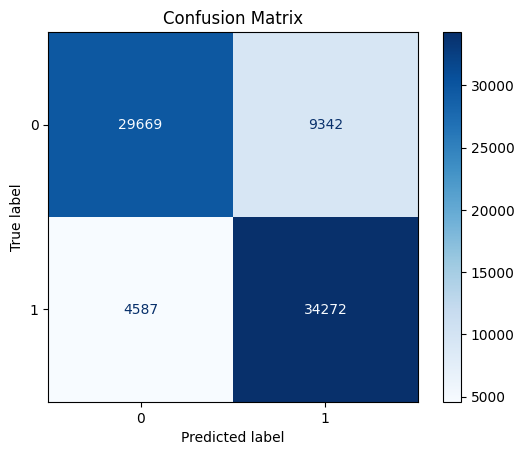

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [127]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Create random forest classifier model
seed = 42
rf_classifier = RandomForestClassifier(random_state=seed)
rf_classifier.fit(X_train, y_train)

# Generate prediction values
y_pred = rf_classifier.predict(X_test)
y_prob = rf_classifier.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division = 0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

ConfusionMatrixDisplay.from_estimator(rf_classifier, X_test, y_test, cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

## BEST MODEL, SAVE TO USE IN R SHINY ##
# import joblib
# joblib.dump(rf_classifier, 'rf_classifier.pkl')
# from google.colab import files
# files.download('rf_classifier.pkl')

## Model 2: Naive Bayes Classifier (with SMOTE)

In [99]:
from sklearn.naive_bayes import GaussianNB

# Create Naive Bayes classifier model
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

# Generate predictions
y_pred = nb_classifier.predict(X_test)
y_prob = nb_classifier.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division = 0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.48      0.54     39011
           1       0.58      0.72      0.64     38859

    accuracy                           0.60     77870
   macro avg       0.61      0.60      0.59     77870
weighted avg       0.61      0.60      0.59     77870

Confusion Matrix:
 [[18662 20349]
 [10870 27989]]
ROC-AUC Score: 0.6423552547235032


## Model 3: XGBoost Classifier (with SMOTE)

In [93]:
from xgboost import XGBClassifier

# Create XGBoost classifier model
seed = 42
xgb_classifier = XGBClassifier(random_state=seed)
xgb_classifier.fit(X_train, y_train)

# Generate predictions
y_pred = xgb_classifier.predict(X_test)
y_prob = xgb_classifier.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division = 0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))


Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.74      0.76     39011
           1       0.75      0.80      0.78     38859

    accuracy                           0.77     77870
   macro avg       0.77      0.77      0.77     77870
weighted avg       0.77      0.77      0.77     77870

Confusion Matrix:
 [[28895 10116]
 [ 7858 31001]]
ROC-AUC Score: 0.8537138226106343


## Model 4: Decision Tree (with SMOTE)

In [94]:
from sklearn.tree import DecisionTreeClassifier

# Create decision tree classifier model
seed = 42
dt_classifier = DecisionTreeClassifier(random_state=seed)
dt_classifier.fit(X_train, y_train)

# Generate predictions
y_pred = dt_classifier.predict(X_test)
y_prob = dt_classifier.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division = 0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.76      0.81     39011
           1       0.78      0.88      0.83     38859

    accuracy                           0.82     77870
   macro avg       0.82      0.82      0.82     77870
weighted avg       0.82      0.82      0.82     77870

Confusion Matrix:
 [[29648  9363]
 [ 4780 34079]]
ROC-AUC Score: 0.9035588928379561


## Model 5: Multilayer Perceptron (MLP)

In [95]:
from sklearn.neural_network import MLPClassifier

# Create MLP classifier model
seed = 42
mlp_classifier = MLPClassifier(random_state=seed)
mlp_classifier.fit(X_train, y_train)

# Generate predictions
y_pred = mlp_classifier.predict(X_test)
y_prob = mlp_classifier.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division = 0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.69      0.72     39011
           1       0.71      0.77      0.74     38859

    accuracy                           0.73     77870
   macro avg       0.73      0.73      0.73     77870
weighted avg       0.73      0.73      0.73     77870

Confusion Matrix:
 [[26793 12218]
 [ 8836 30023]]
ROC-AUC Score: 0.8162438381021504


## Model 6: Stacked Ensemble Model (with SMOTE)

In [100]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# Selected base models to use for stacking classifier
base_models = [
    ('rf', RandomForestClassifier(random_state=seed)),
    ('nb', GaussianNB()),
    ('xgb', XGBClassifier(random_state=seed)),
    ('dt', DecisionTreeClassifier(random_state=seed)),
    ('logistic', LogisticRegression(random_state=seed))
]

# meta-learner layer using logistic regression trained on base models predictions
stack_model = StackingClassifier(estimators=base_models,
                                 final_estimator=LogisticRegression(max_iter = 500,
                                                                    random_state=seed),
                                 cv = 5,
                                 n_jobs = -1)

# Fit model on trained balanced dataset
stack_model.fit(X_train, y_train)

# Generate predictions of stacked classifier model with test dataset
y_pred = stack_model.predict(X_test)
y_prob = stack_model.predict_proba(X_test)[:, 1]

# Evaluate stacked classifier model with metrics
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division = 0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.78      0.81     39011
           1       0.80      0.86      0.83     38859

    accuracy                           0.82     77870
   macro avg       0.82      0.82      0.82     77870
weighted avg       0.82      0.82      0.82     77870

Confusion Matrix:
 [[30435  8576]
 [ 5335 33524]]
ROC-AUC Score: 0.9081175855681827


## Best Baseline Model: Random Forest

After comparing multiple baseline models with each other on various performance metrics, Random Forest outperformed other models and is the suitable choice for feature importance later

## Model 7: PCA + Random Forest (with SMOTE data)

After testingg several baseline models, it is time to try to further optimize and experiment with RandomForest. We combine PCA with RandomForest Classifier to see if PCA can help reduce feature space while preserving most information.

In [103]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA to reduce the number of features
seed = 42
pca = PCA(n_components=0.95, random_state = seed)
X_train_pca = pca.fit_transform(X_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f'Original number of features: {X_scaled.shape[1]}')
print(f'Number of features after PCA: {X_train_pca.shape[1]}')

# Fit Random Forest model with PCA-reduced data
rf_classifier = RandomForestClassifier(random_state=seed)
rf_classifier.fit(X_train_pca, y_train)

# Generate predictions
y_pred = rf_classifier.predict(X_test_pca)
y_prob = rf_classifier.predict_proba(X_test_pca)[:, 1]

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division = 0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

Original number of features: 9
Number of features after PCA: 8
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.76      0.81     39011
           1       0.79      0.88      0.83     38859

    accuracy                           0.82     77870
   macro avg       0.83      0.82      0.82     77870
weighted avg       0.83      0.82      0.82     77870

Confusion Matrix:
 [[29708  9303]
 [ 4605 34254]]
ROC-AUC Score: 0.9084584934786721


## Fine tune baseline Random Forest Model

In [107]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tqdm import tqdm
import numpy as np

results = []
best_model = None
best_auc = 0

for _ in tqdm(range(30), desc="Random Forest Search"):
    model = RandomForestClassifier(
        n_estimators=np.random.randint(100, 500),
        max_depth=np.random.randint(3, 30),
        min_samples_split=np.random.randint(2, 20),
        min_samples_leaf=np.random.randint(1, 20),
        bootstrap=np.random.choice([True, False]),
        random_state=seed
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_prob)

    if auc > best_auc:
        best_auc = auc
        best_model = model

# Evaluate best model
print("Best ROC-AUC:", best_auc)
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

Random Forest Search: 100%|██████████| 30/30 [37:03<00:00, 74.11s/it]


Best ROC-AUC: 0.9011167722995875
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.77      0.81     39011
           1       0.79      0.86      0.82     38859

    accuracy                           0.82     77870
   macro avg       0.82      0.82      0.82     77870
weighted avg       0.82      0.82      0.82     77870

Confusion Matrix:
 [[30006  9005]
 [ 5301 33558]]
ROC-AUC Score: 0.9011167722995875


## Feature Importance of Model

<ipython-input-125-f737c42c261e>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='importance', y='feature', data=feat_df, palette='viridis')


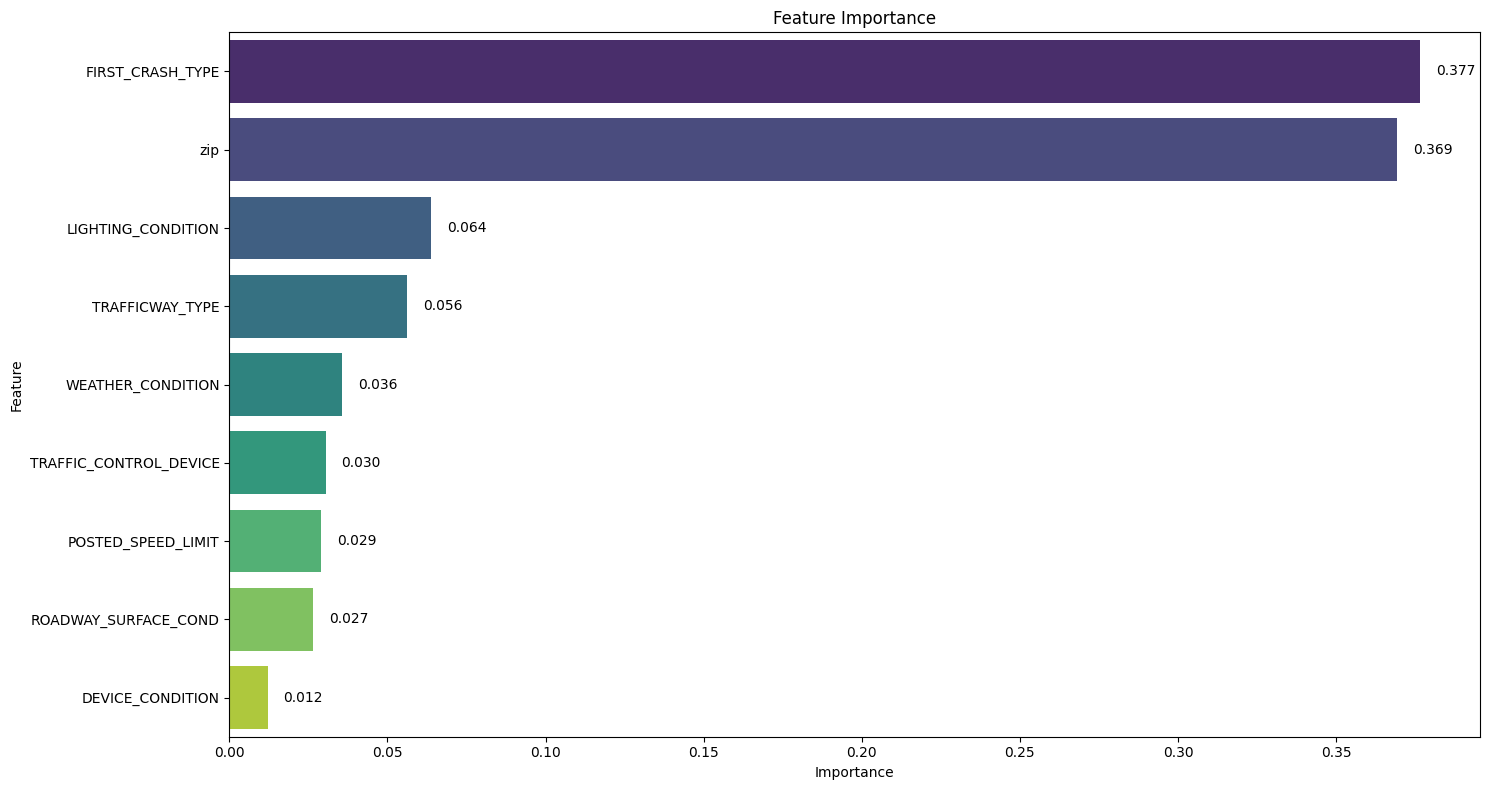

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Retreive feature importances in chart
importances = rf_classifier.feature_importances_
features = X_train.columns

# Create dataframe with feature + importance
feat_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Display plot from greatest to least features and their importance score
plt.figure(figsize=(15, 8))
ax = sns.barplot(x='importance', y='feature', data=feat_df, palette='viridis')

for i, (val, name) in enumerate(zip(feat_df['importance'], feat_df['feature'])):
    ax.text(val + 0.005, i, f"{val:.3f}", va='center')

plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Final Model Performance Summary Comparison (Heatmap + Avg Rank)

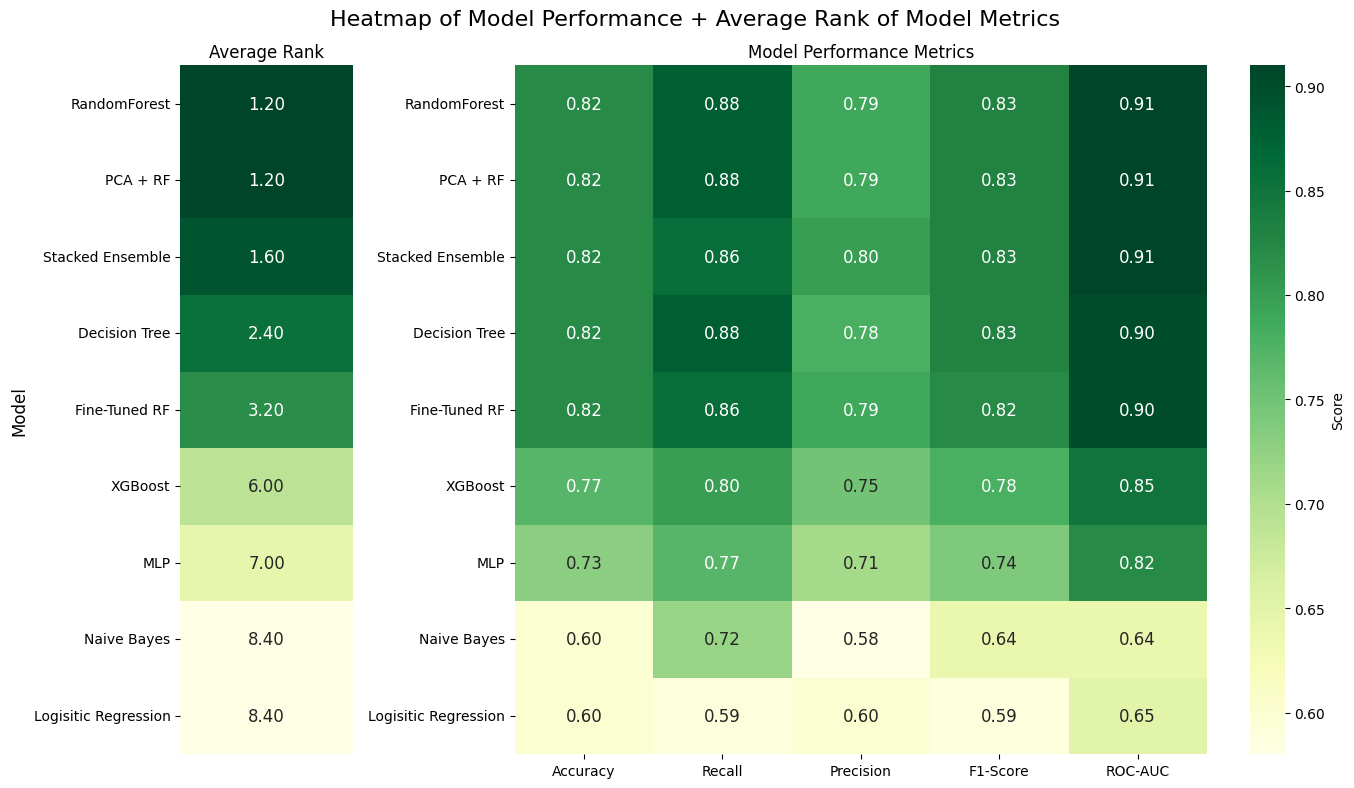

In [121]:
# Create dataframe displaying model performance metrics across various methods
model_results = pd.DataFrame({
    'Model':['Logisitic Regression', 'RandomForest', 'Naive Bayes', 'XGBoost', 'Decision Tree', 'MLP', 'Stacked Ensemble', 'PCA + RF', 'Fine-Tuned RF'],
    'Accuracy': [0.60, 0.82, 0.60, 0.77, 0.82, 0.73, 0.82, 0.82, 0.82],
    'Recall': [0.59, 0.88, 0.72, 0.80, 0.88, 0.77, 0.86, 0.88, 0.86],
    'Precision': [0.60, 0.79, 0.58, 0.75, 0.78, 0.71, 0.80, 0.79, 0.79],
    'F1-Score': [0.59, 0.83, 0.64, 0.78, 0.83, 0.74, 0.83, 0.83, 0.82],
    'ROC-AUC': [0.65, 0.91, 0.64, 0.85, 0.90, 0.82, 0.91, 0.91, 0.90]
})

# Calculate average ranks
score_df = model_results.set_index('Model')
rank_df = score_df.rank(ascending=False, method = 'min', axis=0)
avg_rank = rank_df.mean(axis=1).round(2)

# Insert average rank as a new column for left-side display
display_df = score_df.copy()
display_df.insert(0, 'Avg Rank', avg_rank)

# Sort rows by avg rank, best model is top of heatmap
display_df = display_df.sort_values(by='Avg Rank')

# Split into heatmap values and rank column
rank_column = display_df[['Avg Rank']]
heatmap_values = display_df.drop(columns=['Avg Rank'])

# Set up the grid for plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8), gridspec_kw={'width_ratios': [1, 5]})

# Plot the avg rank as its own heatmap
sns.heatmap(rank_column, annot=True, cmap='YlGn_r', cbar=False, ax=ax1,
            fmt=".2f", annot_kws={"size": 12})
ax1.set_title("Average Rank", fontsize=12)
ax1.set_ylabel("Model", fontsize=12)
ax1.tick_params(axis='y', labelrotation=0)
ax1.tick_params(axis='x', bottom=False, labelbottom=False)

# Plot all metric heatmap + average rank for each model
sns.heatmap(heatmap_values, annot=True, cmap='YlGn', ax=ax2, cbar_kws={'label': 'Score'},
            fmt=".2f", annot_kws={"size": 12})
ax2.set_title("Model Performance Metrics", fontsize=12)
ax2.set_ylabel("")
ax2.tick_params(axis='y', labelrotation=0)

plt.suptitle('Heatmap of Model Performance + Average Rank of Model Metrics', fontsize=16)
plt.tight_layout()
plt.show()


## TOP FEATURE IMPORTANCES TO CLEAR POLICY INSIGHTS

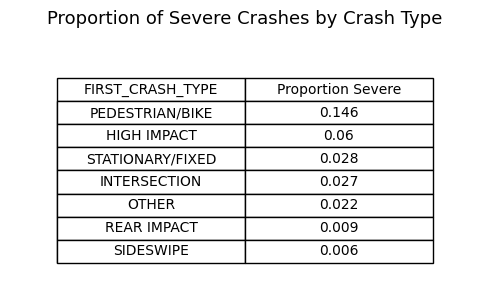

In [155]:
from pandas.plotting import table

crash_type_labels = encoders['FIRST_CRASH_TYPE'].classes_
feature = 'FIRST_CRASH_TYPE'
encoded = df.groupby('FIRST_CRASH_TYPE')['severe'].mean().sort_values(ascending = False)
decoded = encoded.rename(index = lambda x: crash_type_labels[x])

styled_table = decoded.reset_index()
styled_table.columns = [feature, 'Proportion Severe']

fig, ax = plt.subplots(figsize=(5, 3))
ax.axis('off')

tbl = plt.table(
    cellText=styled_table.round(3).values,
    colLabels=styled_table.columns,
    loc='center',
    cellLoc='center',
    colWidths=[0.4] * len(styled_table.columns),
    rowLabels=[""] * styled_table.shape[0]
)

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.5)

plt.title('Proportion of Severe Crashes by Crash Type', fontsize=13, y=1.15)
plt.tight_layout()
plt.show()

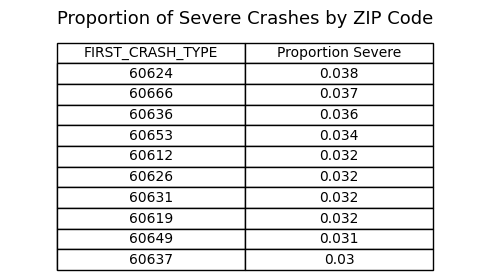

In [156]:
crash_type_labels = encoders['zip'].classes_

encoded = df.groupby('zip')['severe'].mean().sort_values(ascending = False)
decoded = encoded.rename(index = lambda x: crash_type_labels[x])
decoded = decoded.head(10)

styled_table = decoded.reset_index()
styled_table.columns = [feature, 'Proportion Severe']

fig, ax = plt.subplots(figsize=(5, 3))
ax.axis('off')

tbl = plt.table(
    cellText=styled_table.round(3).values,
    colLabels=styled_table.columns,
    loc='center',
    cellLoc='center',
    colWidths=[0.4] * len(styled_table.columns),
    rowLabels=[""] * styled_table.shape[0]
)

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.5)

plt.title('Proportion of Severe Crashes by ZIP Code', fontsize=13, y=1.15)
plt.tight_layout()
plt.show()

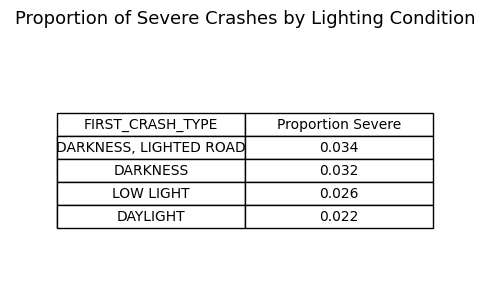

In [157]:
crash_type_labels = encoders['LIGHTING_CONDITION'].classes_

encoded = df.groupby('LIGHTING_CONDITION')['severe'].mean().sort_values(ascending = False)
decoded = encoded.rename(index = lambda x: crash_type_labels[x])


styled_table = decoded.reset_index()
styled_table.columns = [feature, 'Proportion Severe']

fig, ax = plt.subplots(figsize=(5, 3))
ax.axis('off')

tbl = plt.table(
    cellText=styled_table.round(3).values,
    colLabels=styled_table.columns,
    loc='center',
    cellLoc='center',
    colWidths=[0.4] * len(styled_table.columns),
    rowLabels=[""] * styled_table.shape[0]
)

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.5)

plt.title('Proportion of Severe Crashes by Lighting Condition', fontsize=13, y=1.15)
plt.tight_layout()
plt.show()

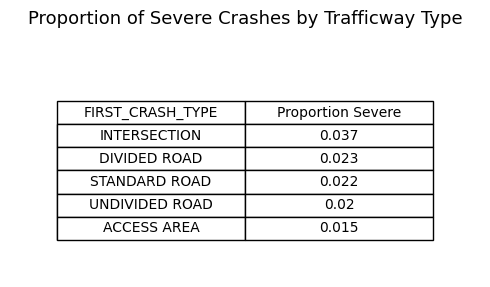

In [158]:
crash_type_labels = encoders['TRAFFICWAY_TYPE'].classes_

encoded = df.groupby('TRAFFICWAY_TYPE')['severe'].mean().sort_values(ascending = False)
decoded = encoded.rename(index = lambda x: crash_type_labels[x])


styled_table = decoded.reset_index()
styled_table.columns = [feature, 'Proportion Severe']

fig, ax = plt.subplots(figsize=(5, 3))
ax.axis('off')

tbl = plt.table(
    cellText=styled_table.round(3).values,
    colLabels=styled_table.columns,
    loc='center',
    cellLoc='center',
    colWidths=[0.4] * len(styled_table.columns),
    rowLabels=[""] * styled_table.shape[0]
)

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.5)

plt.title('Proportion of Severe Crashes by Trafficway Type', fontsize=13, y=1.15)
plt.tight_layout()
plt.show()


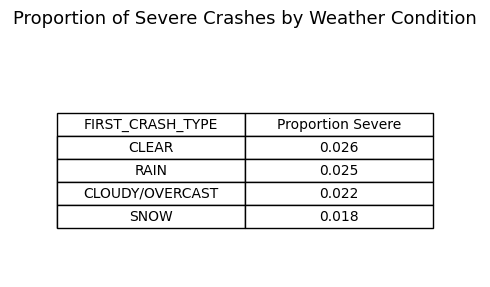

In [159]:
crash_type_labels = encoders['WEATHER_CONDITION'].classes_

encoded = df.groupby('WEATHER_CONDITION')['severe'].mean().sort_values(ascending = False)
decoded = encoded.rename(index = lambda x: crash_type_labels[x])

styled_table = decoded.reset_index()
styled_table.columns = [feature, 'Proportion Severe']

fig, ax = plt.subplots(figsize=(5, 3))
ax.axis('off')

tbl = plt.table(
    cellText=styled_table.round(3).values,
    colLabels=styled_table.columns,
    loc='center',
    cellLoc='center',
    colWidths=[0.4] * len(styled_table.columns),
    rowLabels=[""] * styled_table.shape[0]
)

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.5)

plt.title('Proportion of Severe Crashes by Weather Condition', fontsize=13, y=1.15)
plt.tight_layout()
plt.show()